In [1]:
from os import listdir, mkdir, system
from os.path import isfile, isdir, join, exists
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras import Sequential
from keras.models import Model
from keras.layers import Conv1D, BatchNormalization, Dropout, MaxPooling1D, Flatten, Dense, LSTM, Input, Activation
from keras.callbacks import EarlyStopping
import itertools

# fix random seed for reproducibility
np.random.seed(7)
fs = 300
input_dir = 'One_Hot_Data/'

: 

: 

In [ ]:
# !pip install keras tensorflow

In [6]:
def plot_confusion_matrix(cm, name, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    # plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('ResNet/'+name+'_confmat.png',dpi=250)
    plt.close()


## Loading Data and modelling

4
(61836, 1200, 1)
(61836, 4)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1200, 1)      0                                            
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 1200, 64)     1088        input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 1200, 64)     256         conv1d_6[0][0]                   
__________________________________________________________________________________________________
activation_6 (Activation)       (None, 1200, 64)     0           batch_normalization_6[0][0]      
_______________________________________________________________________________

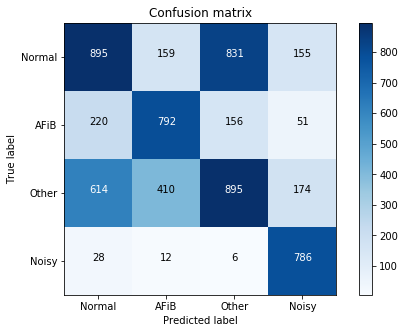

6
(41222, 1800, 1)
(41222, 4)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1800, 1)      0                                            
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 1800, 64)     1088        input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_11 (BatchNo (None, 1800, 64)     256         conv1d_11[0][0]                  
__________________________________________________________________________________________________
activation_11 (Activation)      (None, 1800, 64)     0           batch_normalization_11[0][0]     
_______________________________________________________________________________

KeyboardInterrupt: 

In [4]:
for f in listdir(input_dir):
    
    print (f.split(".")[0])
    OUTPUT_CLASS = 4  # output classes
    k = 1  # increment every 4th residual block
    p = True  # pool toggle every other residual block (end with 2^8)
    convfilt = 64
    convstr = 1
    ksize = 16
    poolsize = 2
    poolstr = 2
    drop = 0.5
    df = pd.read_csv(join(input_dir,f), header=None)
    data = df.values
    X = data[:,:-4]
    X.shape
    X = X.reshape(-1, X.shape[1], 1)
    y = data[:,-4:]
    print (X.shape)
    print (y.shape)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1, shuffle=True)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1, shuffle=True)
    
    input1 = Input(shape=(X_train.shape[1],1), name='input')

    ## First convolutional block (conv,BN, relu)
    x = Conv1D(filters=convfilt, kernel_size=ksize, padding='same', strides=convstr, kernel_initializer='he_normal')(input1)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    ## Second convolutional block (conv, BN, relu, dropout, conv) with residual net
    # Left branch (convolutions)
    x1 = Conv1D(filters=convfilt, kernel_size=ksize, padding='same', strides=convstr, kernel_initializer='he_normal')(x)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x1 = Dropout(drop)(x1)
    x1 = Conv1D(filters=convfilt, kernel_size=ksize, padding='same', strides=convstr, kernel_initializer='he_normal')(x1)
    x1 = MaxPooling1D(pool_size=poolsize, strides=poolstr)(x1)

    # Right branch, shortcut branch pooling
    x2 = MaxPooling1D(pool_size=poolsize, strides=poolstr)(x)

    # Merge both branches
    x = keras.layers.add([x1, x2])

    del x1, x2

    ## Main loop
    p = not p
    for l in range(5):

        if (l % 4 == 0) and (l > 0):  # increment k on every fourth residual block
            k += 1
            # increase depth by 1x1 Convolution case dimension shall change
            xshort = Conv1D(filters=convfilt * k, kernel_size=1)(x)
        else:
            xshort = x
            # Left branch (convolutions)
        # notice the ordering of the operations has changed
        x1 = BatchNormalization()(x)
        x1 = Activation('relu')(x1)
        x1 = Dropout(drop)(x1)
        x1 = Conv1D(filters=convfilt * k, kernel_size=ksize, padding='same', strides=convstr, kernel_initializer='he_normal')(x1)
        x1 = BatchNormalization()(x1)
        x1 = Activation('relu')(x1)
        x1 = Dropout(drop)(x1)
        x1 = Conv1D(filters=convfilt * k, kernel_size=ksize, padding='same', strides=convstr, kernel_initializer='he_normal')(x1)
        if p:
            x1 = MaxPooling1D(pool_size=poolsize, strides=poolstr)(x1)

            # Right branch: shortcut connection
        if p:
            x2 = MaxPooling1D(pool_size=poolsize, strides=poolstr)(xshort)
        else:
            x2 = xshort  # pool or identity
        # Merging branches
        x = keras.layers.add([x1, x2])
        # change parameters
        p = not p  # toggle pooling

    # Final bit
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Flatten()(x)
    # x = Dense(1000)(x)
    # x = Dense(1000)(x)
    out = Dense(OUTPUT_CLASS, activation='softmax')(x)
    model = Model(inputs=input1, outputs=out)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    
    history = model.fit(X_train, y_train, batch_size=128, epochs=250, verbose=1, validation_data=(X_val, y_val), 
            callbacks=[EarlyStopping(monitor='val_loss', patience=15, verbose=1)])
    
    
    accuracy = history.history['acc']
    val_accuracy = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(accuracy))
    plt.figure(figsize=(8,4))
    plt.plot(epochs, accuracy, label='Training accuracy')
    plt.plot(epochs, val_accuracy, label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('ResNet/'+f[0]+'_acc.png',dpi=200)
    plt.close()

    plt.figure(figsize=(8,4))
    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('ResNet/'+f[0]+'_loss.png',dpi=200)
    plt.close()

    model.save('ResNet/'+f[0]+"_model.h5py")
    
    new_y_pred = model.predict(X_test)
    y_test_arg = np.argmax(np.round(y_test),axis=1)
    y_pred_arg = np.argmax(np.round(new_y_pred),axis=1)
    y_pred = np.zeros((new_y_pred.shape[0],new_y_pred.shape[1]))

    from pycm import *
    cm = ConfusionMatrix(actual_vector=y_test_arg, predict_vector=y_pred_arg)
    totalt = cm.__dict__

    TP = totalt['TP']
    FP = totalt['FP']
    TN = totalt['TN']
    FN = totalt['FN']

    PPV = totalt['PPV']
    ACC = totalt['ACC']
    SEN = totalt['TPR']
    SPE = totalt['TNR']
    F1S = totalt['F1']
    AUC = totalt['AUC']

    print ('TP,FP,TN,FN,Precision,Accuracy,Sensitivity,Specificity,F1Score,AUC')
    print (TP[0], ',', FP[0], ',', TN[0], ',', FN[0], ',', '{:.2f}%'.format(PPV[0]*100), ',', '{:.2f}%'.format(ACC[0]*100), ',', '{:.2f}%'.format(SEN[0]*100), ',','{:.2f}%'.format(SPE[0]*100), ',','{:.2f}%'.format(F1S[0]*100), ',','{:.2f}%'.format(AUC[0]*100))
    print (TP[1], ',', FP[1], ',', TN[1], ',', FN[1], ',', '{:.2f}%'.format(PPV[1]*100), ',','{:.2f}%'.format(ACC[1]*100), ',','{:.2f}%'.format(SEN[1]*100), ',','{:.2f}%'.format(SPE[1]*100), ',','{:.2f}%'.format(F1S[1]*100), ',','{:.2f}%'.format(AUC[1]*100))
    print (TP[2], ',', FP[2], ',', TN[2], ',', FN[2], ',', '{:.2f}%'.format(PPV[2]*100), ',','{:.2f}%'.format(ACC[2]*100), ',','{:.2f}%'.format(SEN[2]*100), ',','{:.2f}%'.format(SPE[2]*100), ',','{:.2f}%'.format(F1S[2]*100), ',','{:.2f}%'.format(AUC[2]*100))


    for i in range(y_pred.shape[0]):
        y_pred[i][y_pred_arg[i]] = 1

    print (classification_report(y_test, y_pred))
    cnf_matrix = confusion_matrix(y_test_arg, y_pred_arg)

    # Plot non-normalized confusion matrix
    class_names = ['Normal','AFiB','Other', 'Noisy']
    plt.figure(figsize=(8,5))
    plot_confusion_matrix(cnf_matrix, name = f[0], classes=class_names, title='Confusion matrix')

In [ ]:
# model.add(Flatten())

# model.add(Dense(128, activation='relu'))
# model.add(Dense(y.shape[1], activation='softmax'))


# model.add(Conv2D(512, 3, strides=(32, 4), padding='same', input_shape=(1, 32, None)))
# model.add(Reshape((512, -1)))
# model.add(Permute((2, 1)))
# model = Sequential()
# model.add(LSTM(200, activation='relu', input_shape=(X.shape[1],1)))

In [ ]:
# 81% recall. That means the model correctly identified 81% of the total bad loans. That’s pretty great. 
# But is this actually representative of how the model will perform? To find out, I’ll calculate the accuracy 
# and recall for the model on the test dataset I created initially.
# By oversampling before splitting into training and validation datasets, I “bleed” information from the
# validation set into the training of the model.

# To see how this works, think about the case of simple oversampling (where I just duplicate observations). 
# If I upsample a dataset before splitting it into a train and validation set, I could end up with the same 
# observation in both datasets. As a result, a complex enough model will be able to perfectly predict the value 
# for those observations when predicting on the validation set, inflating the accuracy and recall.

# When upsampling using SMOTE, I don’t create duplicate observations. However, because the SMOTE algorithm uses
# the nearest neighbors of observations to create synthetic data, it still bleeds information. If the nearest 
# neighbors of minority class observations in the training set end up in the validation set, their information 
# is partially captured by the synthetic data in the training set. Since I’m splitting the data randomly, we’d
# expect to have this happen. As a result, the model will be better able to predict validation set values than
# completely new data.
